In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy.io as sio
from scipy.stats import ortho_group
from sklearn.svm import SVC 
import math 
import random
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.linear_model import orthogonal_mp

import time

In [2]:
cd Desktop/LANL/AFRL-DISC Data/Blackbox brief for LANL

C:\Users\khenk\Desktop\LANL\AFRL-DISC Data\Blackbox brief for LANL


In [3]:
sPCA= pd.read_csv('sPCA_32.csv', sep=',', encoding = 'utf8')
data = sPCA.values
#Load sPCA Dictionary from found sPCA components
mat = sio.loadmat('sPCA_Phi.mat')
sPCA_Phi = mat['sPCA_Phi']

mat = sio.loadmat('fMnist_ytrainlabels.mat')
y_train = np.squeeze(np.asarray(mat['y_train'].T))
mat = sio.loadmat('fMnist_ytestlabels.mat')
y_test = np.squeeze(np.asarray(mat['y_test'].T))


In [4]:
#normalize data
for i in range(len(data)):
    if LA.norm(data[i])!=0:
        data[i]=data[i]/LA.norm(data[i])

In [5]:
#Gett 6 features from each class and 4 Random
Selected_Features = []
for i in range(10):
    index = np.where(y_train==i)
    for i in range(6):
        Selected_Features.append(index[0][i])

max_element = max(Selected_Features)
for i in range(1,5):
    print(max_element)
    Selected_Features.append(max_element+i)
Selected_Features = np.asarray(Selected_Features)

105
105
105
105


In [6]:
#Get Features for data phi and Normalize
Neurons = 64
Phi = data[Selected_Features,:]
Phi = Phi.T
Phi = np.asmatrix(Phi)
for i in range(Neurons):
    if LA.norm(Phi[:,i])!=0:
        Phi[:,i]= Phi[:,i]/(LA.norm(Phi[:,i]))

In [7]:
def sparse_loss(I,Phi,sparse_representation_coefficients,lam):
    Energy = .5*LA.norm(I-np.dot(Phi,sparse_representation_coefficients))**2 +lam*np.count_nonzero(sparse_representation_coefficients)
    return Energy

def reconstruction_loss(I,Phi,sparse_representation_coefficients):
    Loss = LA.norm(I-np.dot(Phi,sparse_representation_coefficients))**2
    return Loss

In [8]:
Phi_Original = Phi

In [9]:
#SGD Loop to update Dictionary
Data_Patches = data[0:len(y_train)]
mini_batch_size = 512
tol = 10**(-32)
max_iterations = 100000
eta =.0001 #Learning Rate (Lower is better)
lam = .8
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
count = 0
Previous_Gradient = 0
momentum_term = .9



Total_Energies = []
Total_Recon_Loss = []
Non_Zero_Coefficients =[] #Helps see how sparse reconstructions are while learning
eta_initial =.01
eta_final = .000001#Learning Rate (Lower is better)
eta = eta_initial
for iteration in range(max_iterations):
    
        
    #Random Draw from Data
    Indexing = random.sample(range(len(Data_Patches)), mini_batch_size)
    
    Neuron_Activation =[]
    Gradients =[]
    Unembedded_Solutions_Training= []
    t1 = time.time()
    New_Solutions = []
    Temp_Data_Patches=[]
    Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))
    


    image_number = 0
    
    #################### SGD With Hebbian Rule #################
    Sparse_Rep=[]
    Loss = []
    Sparsity_Loss = []
    Gradients = []
    for sample in Indexing:
        #Getting solutions off of whatever device
        temp = orthogonal_mp(Phi,Data_Patches[sample])
        #Finding Losses Offline
        Sparsity_Loss.append((sparse_loss(Data_Patches[sample],Phi,temp.T,lam)))
        Sparse_Rep.append(temp)
        Loss.append(LA.norm(Data_Patches[sample]-np.dot(Phi,temp.T)))
        error = np.subtract(Data_Patches[sample].T,np.squeeze(np.dot(Phi,temp.T)))
        #Getting gradient for image
        Delta_Phi =np.outer(error,temp)
        Delta_Phi = np.asarray(Delta_Phi)
        Gradients.append(Delta_Phi)
    #Averageing gradients over minibatch    
    Gradient = sum(np.asarray(Gradients))/mini_batch_size
    Phi_New = Phi - (eta)*Gradient + momentum_term*Previous_Gradient #non division by mini batch size
    Previous_Gradient = Gradient
    
    #Normalize new Dictionary
    for i in range(Neurons):
        Phi_New[:,i]= Phi_New[:,i]/(math.sqrt(np.dot(Phi_New[:,i].T,Phi_New[:,i])))
    Previous_Gradient = Gradient 
    ###################### End of Dictionary Update #################

    Loss = sum(np.asarray(Loss))/len(Indexing)
    Sparsity_Loss = sum(np.asarray(Sparsity_Loss))/len(Indexing)
    Total_Energies.append(Sparsity_Loss)
    Total_Recon_Loss.append(Loss)

#
    
    if count%10==0:
        print(count)
        print(Loss,Sparsity_Loss,np.count_nonzero(Sparse_Rep))
        print(LA.norm(Phi_New-Phi))
    #print(plt.plot(range(iteration+1), Total_Energies ))
    #print('Energies,Epoc :', Total_Energies,count)
    elapsed1 = time.time() - t1
    #print(elapsed1)
    count += 1

#     sio.savemat('Phi_New_Fashion_MiniBatch1000_sPCA_AFRL_32_Lambda_'+str(lam)+'_OMP.mat', {'Phi_New':Phi_New})
#     sio.savemat('TotalEnergies_Fashion_MiniBatch1000_sPCA_AFRL_32_Lambda_'+str(lam)+'_OMP.mat', {'Total_Energies':Total_Energies})
    if LA.norm(Phi_New-Phi) > tol:
        #print(LA.norm(Phi_New-Phi))
        Phi = Phi_New
        eta = eta_initial*((eta_final/float(eta_initial))**(iteration/float(max_iterations))) #exponentially decaying learing rate


    else:
        print('converged')
        
        break


0
(0.3409164770313883, 4.864359086420886, 3072)
0.0002456723102430878
10
(0.3257696322285733, 4.859323806476614, 3072)
0.020883204399918753
20
(0.32597708529281166, 4.858813822093172, 3072)
0.018867566926780283
30
(0.3191006460146612, 4.857033456205804, 3072)
0.017742507845810718
40
(0.31763754049440746, 4.856441666074829, 3072)
0.01745036223567082
50
(0.31299973622119504, 4.854878512657599, 3072)
0.017323945462984852
60
(0.31492618976506837, 4.855522265359307, 3072)
0.014939574284239705
70
(0.29364566709566325, 4.848911509114941, 3072)
0.015222708430287973
80
(0.28856371542984843, 4.847394566827077, 3072)
0.015184955563514178
90
(0.29737506397150926, 4.849699031474573, 3072)
0.015055328896033723
100
(0.29436175349151283, 4.848703924350914, 3072)
0.014740273097782053
110
(0.2956061312753055, 4.849567369971367, 3072)
0.013403043600130322
120
(0.2857614661724904, 4.846350743333055, 3072)
0.013965294977538196
130
(0.29112743972180233, 4.848119835533603, 3072)
0.013317577178992934
140
(0.2

1150
(0.2448048054237862, 4.834590680230197, 3072)
0.010377426942835964
1160
(0.24591827545016998, 4.8346874633468895, 3072)
0.0112266383092253
1170
(0.24443408769293973, 4.83420658218879, 3072)
0.011310352759377744
1180
(0.25257632073317965, 4.836561213110533, 3072)
0.010486916370427878
1190
(0.2553937264615907, 4.837261173523814, 3072)
0.010219481204385978
1200
(0.2435005866270268, 4.834237998169744, 3072)
0.01026683326966734
1210
(0.2501436925899434, 4.835232495007695, 3072)
0.010510659033603714
1220
(0.24593008368172584, 4.834747473823255, 3072)
0.010582099105634209
1230
(0.25289523424978866, 4.836753479623438, 3072)
0.01095777537108706
1240
(0.24566403711200918, 4.834180348889005, 3072)
0.01078136270693794
1250
(0.25018617205102894, 4.835665422350962, 3072)
0.010586661646332958
1260
(0.24667451323404221, 4.834978294913134, 3072)
0.01056620050161401
1270
(0.25286031619785987, 4.837094893508921, 3072)
0.010281135475031473
1280
(0.24950807509462783, 4.835673012372815, 3072)
0.0109350

KeyboardInterrupt: 

In [10]:
#Get Linear Regression function
def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys))/((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    
    b = np.mean(ys) - m*np.mean(xs)
    
    return m, b

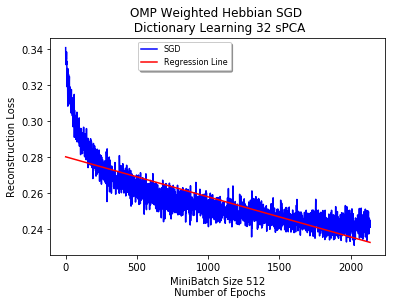

In [20]:
#Plot Learning Results
energy = np.asarray(Total_Recon_Loss)
low = min(energy)
xs = np.asarray(range(len(energy)))#np.array([1,2,3,4,5], dtype=np.float64)
ys = np.asarray(energy)# np.array([5,4,6,5,6], dtype=np.float64)

#Get linear regression best fit line
m, b = best_fit_slope_and_intercept(xs,ys)

regression_line = [(m*x)+b for x in xs]
a = range(len(energy))
b = energy
c = regression_line
d = [min(energy)]*len(energy)
#e = Total_Recon_Loss

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(a, b, 'k',color='blue',label='SGD')
ax.plot(a, c, 'k', color='red',label='Regression Line')
#ax.plot(a, d, 'k',color='green', label='Min')
#ax.plot(a, e, 'k', label='Reconstruction')
#ax.axvline(x=19,linestyle='--', label ='Dropped Learning Rate')
# ax.axvline(x=220,linestyle='--', color='red',label ='Increase Learning Rate')
# ax.axvline(x=240,linestyle='--')
legend = ax.legend(loc='best', bbox_to_anchor=(0.55,1), shadow=True, fontsize='x-large',prop={'size': 8})
plt.xlabel('MiniBatch Size '+str(mini_batch_size)+'\n Number of Epochs' ),
plt.ylabel('Reconstruction Loss');
plt.title('OMP Weighted Hebbian SGD \n Dictionary Learning 32 sPCA')#Lambda = '+str(lam)+'  Tunned')
        
# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('C0')

plt.show()

In [12]:
#Get Features from data for phi and Normalize
#Get back orignal phi
Neurons = 64
Phi = data[Selected_Features,:]
Phi = Phi.T
Phi = np.asmatrix(Phi)
for i in range(Neurons):
    if LA.norm(Phi[:,i])!=0:
        Phi[:,i]= Phi[:,i]/(LA.norm(Phi[:,i]))

In [14]:
Phi_Original = np.dot(Phi.T,sPCA_Phi)
Phi_Original.shape

(64L, 784L)

In [15]:
Phi_New = np.dot(Phi_New.T,sPCA_Phi)
Phi_Original.shape

(64L, 784L)

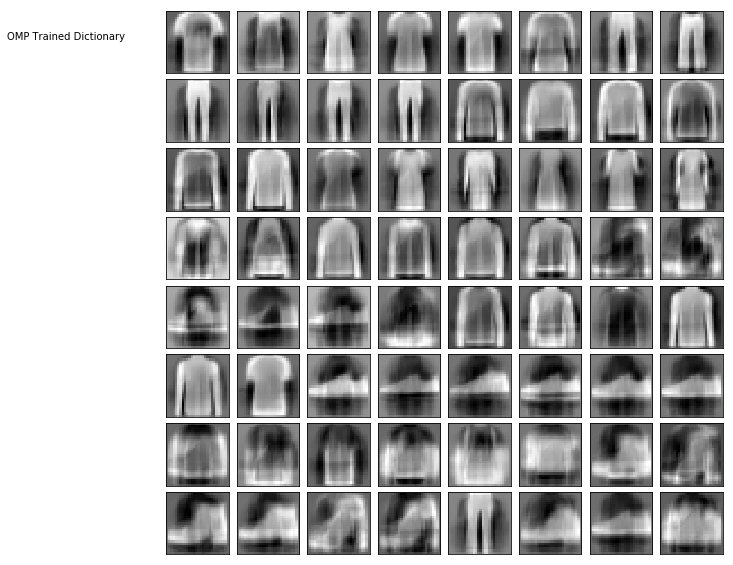

In [17]:
# Plot the results
fig, ax = plt.subplots(8, 8, figsize=(10, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(Phi_Original[(i*8)+j].reshape(28,28), cmap='binary_r')
#     ax[1, i].imshow(np.asarray(Repatched_Data[i]), cmap='binary_r')
#     ax[2, i].imshow(np.asarray(Original[i]), cmap='binary_r')
    #print(immatrix[i].reshape(32,32).shape)
    #ax[2, i].imshow(All_Reconstructions_Trained_Final[i].reshape(28,28), cmap='binary_r')
    #print(projected[i].reshape(32,32).shape)
    
ax[0, 0].set_ylabel('OMP Starting Features Reconstructed',rotation=0,labelpad=100);

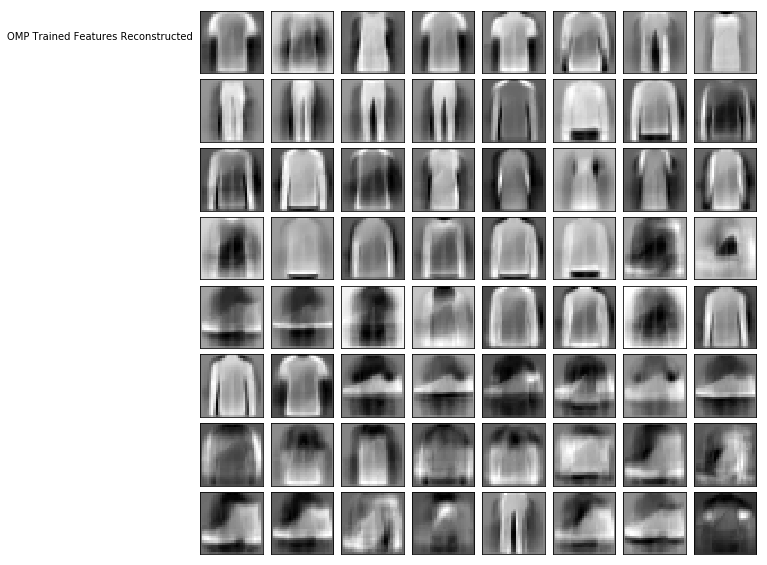

In [18]:
# Plot the results
fig, ax = plt.subplots(8, 8, figsize=(10, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(Phi_New[(i*8)+j].reshape(28,28), cmap='binary_r')
#     ax[1, i].imshow(np.asarray(Repatched_Data[i]), cmap='binary_r')
#     ax[2, i].imshow(np.asarray(Original[i]), cmap='binary_r')
    #print(immatrix[i].reshape(32,32).shape)
    #ax[2, i].imshow(All_Reconstructions_Trained_Final[i].reshape(28,28), cmap='binary_r')
    #print(projected[i].reshape(32,32).shape)
    
ax[0, 0].set_ylabel('OMP Trained Features Reconstructed',rotation=0,labelpad=100);

In [90]:
#Get Features from data for phi and Normalize
#Get back orignal phi
Neurons = 64
Phi = data[Selected_Features,:]
Phi = Phi.T
Phi = np.asmatrix(Phi)
for i in range(Neurons):
    if LA.norm(Phi[:,i])!=0:
        Phi[:,i]= Phi[:,i]/(LA.norm(Phi[:,i]))

In [91]:
#Reconstruct the data sets with each dictionary
Trained_Rep = []
UnTrained_Rep = []
for i in range(len(data)):
    Trained_Rep.append(orthogonal_mp(Phi_New,data[i]))
    UnTrained_Rep.append(orthogonal_mp(Phi,data[i]))


In [92]:
Trained_Rep = np.asarray(Trained_Rep)
UnTrained_Rep = np.asarray(UnTrained_Rep)
All_Reconstructions_Trained  = np.dot(Trained_Rep,Phi_New.T)
All_Reconstructions_UnTrained  = np.dot(Untrained_Rep,Phi.T)

In [93]:
#Reconstruct back to original data dimensions
sPCA_Reconstruction = np.dot(data,sPCA_Phi)
All_Reconstructions_UnTrained_Final = np.dot(All_Reconstructions_UnTrained,sPCA_Phi)
All_Reconstructions_Trained_Final = np.dot(All_Reconstructions_Trained,sPCA_Phi)

In [94]:
Untrained_Error = []
Trained_Error = []
for i in range(len(Untrained_Rep)):
    Untrained_Error.append(LA.norm(All_Reconstructions_UnTrained[i]-data[i]))
    Trained_Error.append(LA.norm(All_Reconstructions_Trained[i]-data[i]))
print('Average Error Untrained',np.sum(Untrained_Error)/len(Untrained_Rep))
print('Average Error Trained', np.sum(Trained_Error)/len(Trained_Error))

('Average Error Untrained', 0.3368799405978321)
('Average Error Trained', 0.2658630131331454)


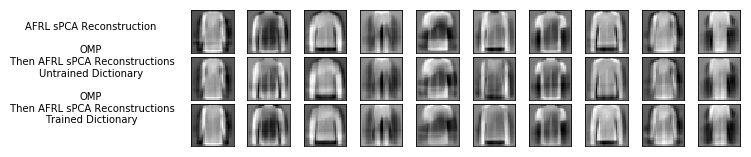

In [95]:
# Plot the results for data outside original features for first dictionary
fig, ax = plt.subplots(3, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(sPCA_Reconstruction[i+500].reshape(28,28), cmap='binary_r')
    ax[1, i].imshow(All_Reconstructions_UnTrained_Final[i+500].reshape(28,28), cmap='binary_r')
    #print(immatrix[i].reshape(32,32).shape)
    ax[2, i].imshow(All_Reconstructions_Trained_Final[i+500].reshape(28,28), cmap='binary_r')
    #print(projected[i].reshape(32,32).shape)
    
ax[0, 0].set_ylabel('AFRL sPCA Reconstruction',rotation=0,labelpad=100)
ax[1, 0].set_ylabel('OMP\n Then AFRL sPCA Reconstructions\nUntrained Dictionary',rotation=0,labelpad=100);
ax[2, 0].set_ylabel('OMP\n Then AFRL sPCA Reconstructions\nTrained Dictionary',rotation=0,labelpad=100);